# Reddit

Here we are doing sentiment analysis of comments on Reddit

In [1]:
import pandas as pd
import nltk
from nltk.corpus import stopwords
from string import ascii_letters, punctuation

ENG_STOPWORDS = stopwords.words('english')

df = pd.read_csv('covid_Reddit_output_26_03_2020.csv')

In [2]:
for row in df['top_main_comment']:
    df['top_main_comment'].replace
    type_row = type(row)
    if(type_row != "str"):
#         print(type_row)
        str(type_row)
df = df.astype(str)

In [3]:
top_main_comment = df[['top_main_comment', 'timestamp']].apply(lambda x: [[y for y in x['top_main_comment'].split('\n') if y != '' and not y.startswith('=== Author: ')], x['timestamp']], axis=1)
orig_comments, timestamps = [], []
for comment in top_main_comment:
    orig_comments.extend(comment[0])
    timestamps.extend([comment[1]] * len(comment[0]))

In [4]:
comments = [x for x in orig_comments]
for i in range(len(comments)):
    comment = ''.join([ch.lower() for ch in comments[i] if ch in ascii_letters or ch == ' '])
    comment = ' '.join([word for word in comment.split() if word not in ENG_STOPWORDS])
    comments[i] = comment

In [5]:
comments_df = pd.DataFrame(comments, columns=['Comment'])
comments_df['Original_Comment'] = orig_comments
comments_df['Timestamp'] = timestamps

print(len(comments_df))
comments_df.drop(comments_df.loc[comments_df['Comment'] == ''].index, inplace=True)
comments_df.drop(comments_df.loc[comments_df['Comment'] == 'advertisement'].index, inplace=True)
comments_df.drop(comments_df.loc[comments_df['Original_Comment'].str.contains('1.0.1 |[Source code](https://github.com/fterh/sneakpeek) | [Contribute](https://github.com/fterh/sneakpeek)')].index, inplace=True)
comments_df.drop(comments_df.loc[comments_df['Original_Comment'].str.contains('0.6.0-beta |[Source code](https://github.com/fterh/sneakpeek) | [Contribute](https://github.com/fterh/sneakpeek)')].index, inplace=True)
comments_df.drop(comments_df.loc[comments_df['Original_Comment'].str.contains('0.5.0-beta |[Source code](https://github.com/fterh/sneakpeek) | [Contribute](https://github.com/fterh/sneakpeek)')].index, inplace=True)
comments_df.drop(comments_df.loc[comments_df['Original_Comment'].str.startswith('[https://')].index, inplace=True)
comments_df.drop(comments_df.loc[comments_df['Original_Comment'].str.startswith('v4.0 | [Github](https://github.com/fterh/rsg-retrivr) | [Readme/Changelog](https://github.com/fterh/rsg-retrivr/blob/master/README.md) | Summon me: `/u/rsg-retrivr summon`')].index, inplace=True)
comments_df.drop(comments_df.loc[comments_df['Original_Comment'].str.startswith('> ')].index, inplace=True)  # drop quoted comments
comments_df.drop(comments_df.loc[comments_df['Original_Comment'].str.startswith('"> ')].index, inplace=True)  # drop quoted comments
print(len(comments_df))
filters = 'covid,covid19,coronavirus,fear,anxious,panic,scare,panic buying,out of stock,quarantine,loa,spread,dorscon level,masks,toilet paper'.split(',')
comments_df.drop(comments_df.loc[~comments_df['Comment'].str.contains('|'.join(filters))].index, inplace=True)  # drop comments without the keywords
print(len(comments_df))
comments_df.reset_index(inplace=True)
comments_df.info()

19211


C:\Users\Min\Anaconda3\lib\site-packages\pandas\core\strings.py:1843: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)


16770
1805
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1805 entries, 0 to 1804
Data columns (total 4 columns):
index               1805 non-null int64
Comment             1805 non-null object
Original_Comment    1805 non-null object
Timestamp           1805 non-null object
dtypes: int64(1), object(3)
memory usage: 56.5+ KB


In [6]:
# Import packages
import nltk
from pprint import pprint
import yaml
import sys
import os
import re

dict_tagged_sentences = ''
# Below indicates the relative path to
# positive/negative/inverter/incrementer/decrementer files
DICTIONARY_DIR_PREFIX = 'dicts2/'

class Splitter(object):
    def __init__(self):
        self.nltk_splitter = nltk.data.load('tokenizers/punkt/english.pickle')
        self.nltk_tokenizer = nltk.tokenize.TreebankWordTokenizer()

    def split(self, text):
        """
        input format: a paragraph of text
        output format: a list of lists of words.
            e.g.: [['this', 'is', 'a', 'sentence'], ['this', 'is', 'another', 'one']]
        """
        sentences = self.nltk_splitter.tokenize(text)
        tokenized_sentences = [self.nltk_tokenizer.tokenize(sent) for sent in sentences]
        return tokenized_sentences


class POSTagger(object):
    def __init__(self):
        pass

    def pos_tag(self, sentences):
        """
        input format: list of lists of words
            e.g.: [['this', 'is', 'a', 'sentence'], ['this', 'is', 'another', 'one']]
        output format: list of lists of tagged tokens. Each tagged tokens has a
        form, a lemma, and a list of tags
            e.g: [[('this', 'this', ['DT']), ('is', 'be', ['VB']), ('a', 'a', ['DT']), ('sentence', 'sentence', ['NN'])],
                    [('this', 'this', ['DT']), ('is', 'be', ['VB']), ('another', 'another', ['DT']), ('one', 'one', ['CARD'])]]
        """

        pos = [nltk.pos_tag(sentence) for sentence in sentences]
        #adapt format
        pos = [[(word, word, [postag]) for (word, postag) in sentence] for sentence in pos]
        return pos

class DictionaryTagger(object):
    def __init__(self, dictionary_paths):
        """

        :rtype : object
        """
        files = [open(path, 'r') for path in dictionary_paths]
        dictionaries = [yaml.load(dict_file) for dict_file in files]
        map(lambda x: x.close(), files)
        self.dictionary = {}
        self.max_key_size = 0
        for curr_dict in dictionaries:
            for key in curr_dict:
                if key in self.dictionary:
                    self.dictionary[key].extend(curr_dict[key])
                else:
                    self.dictionary[key] = curr_dict[key]
                    self.max_key_size = max(self.max_key_size, len(key))

    def tag(self, postagged_sentences):
        return [self.tag_sentence(sentence) for sentence in postagged_sentences]

    def tag_sentence(self, sentence, tag_with_lemmas=False):
        """
        the result is only one tagging of all the possible ones.
        The resulting tagging is determined by these two priority rules:
            - longest matches have higher priority
            - search is made from left to right
        """
        tag_sentence = []
        N = len(sentence)
        if self.max_key_size == 0:
            self.max_key_size = N
        i = 0
        while (i < N):
            j = min(i + self.max_key_size, N) #avoid overflow
            tagged = False
            while (j > i):
                expression_form = ' '.join([word[0] for word in sentence[i:j]]).lower()
                expression_lemma = ' '.join([word[1] for word in sentence[i:j]]).lower()
                if tag_with_lemmas:
                    literal = expression_lemma
                else:
                    literal = expression_form
                if literal in self.dictionary:
                    #self.logger.debug("found: %s" % literal)
                    is_single_token = j - i == 1
                    original_position = i
                    i = j
                    taggings = [tag for tag in self.dictionary[literal]]
                    tagged_expression = (expression_form, expression_lemma, taggings)
                    if is_single_token: #if the tagged literal is a single token, conserve its previous taggings:
                        original_token_tagging = sentence[original_position][2]
                        tagged_expression[2].extend(original_token_tagging)
                    tag_sentence.append(tagged_expression)
                    tagged = True
                else:
                    j = j - 1
            if not tagged:
                tag_sentence.append(sentence[i])
                i += 1
        return tag_sentence

def value_of(sentiment):
    if sentiment == 'positive1': return 1
    if sentiment == 'positive2': return 2
    if sentiment == 'positive3': return 3
    if sentiment == 'negative1': return -1
    if sentiment == 'negative2': return -2
    if sentiment == 'negative3': return -3
    return 0

def sentiment_score(review):
    return sum ([value_of(tag) for sentence in dict_tagged_sentences for token in sentence for tag in token[2]])

def sentence_score(sentence_tokens, previous_token, acum_score):
    if not sentence_tokens:
        return acum_score
    else:
        current_token = sentence_tokens[0]
        tags = current_token[2]
        token_score = sum([value_of(tag) for tag in tags])
        if previous_token is not None:
            previous_tags = previous_token[2]
            if 'inc' in previous_tags:
                token_score *= 2.0
            elif 'dec' in previous_tags:
                token_score /= 2.0
            elif 'inv' in previous_tags:
                token_score *= -1.0
        return sentence_score(sentence_tokens[1:], current_token, acum_score + token_score)

def sentiment_score(sentences):
    return sum([sentence_score(sentence, None, 0.0) for sentence in sentences])


def run_analysis(text):
    splitter = Splitter() # This boy will split a long single string into sentences.
    postagger = POSTagger() # This boy is the Part-Of-Speech tagger.

    # If text contains multiple sentences, this line splits it into individual sentences.
    splitted_sentences = splitter.split(text)
    print (splitted_sentences)
    #exit(1)

    print ("########## This performs Part-Of-Speech tagging. ##########")
    # This performs Part-Of-Speech tagging.
    pos_tagged_sentences = postagger.pos_tag(splitted_sentences)
    #pprint (pos_tagged_sentences)
    #exit(1)

    print ("########## This line loads Positive word and Negative word corpus. ##########")
    # This line loads Positive word and Negative word dictionaries.
    dicttagger = DictionaryTagger([ DICTIONARY_DIR_PREFIX + 'positive.yml', DICTIONARY_DIR_PREFIX + 'negative.yml'])
    dict_tagged_sentences = dicttagger.tag(pos_tagged_sentences)
    #pprint(dict_tagged_sentences)
    #exit(1)

    print ("########## [Baseline Analysis] Using only Positive/Negative corpus. ##########")
    score = sentiment_score(dict_tagged_sentences)
    print ("Score: %d" % score)
    #exit(1)

    print ("########## This line loads Positve/Negative corpus + incrementer/decrementer corpus. ##########")
    dicttagger = DictionaryTagger([ DICTIONARY_DIR_PREFIX + 'positive.yml', DICTIONARY_DIR_PREFIX + 'negative.yml', DICTIONARY_DIR_PREFIX + 'inc.yml', DICTIONARY_DIR_PREFIX + 'dec.yml'])
    dict_tagged_sentences = dicttagger.tag(pos_tagged_sentences)
    #pprint(dict_tagged_sentences)
    score = sentiment_score(dict_tagged_sentences)
    print ("Score: %d" % score)
    #exit(1)

    print ("########## This line loads Positve/Negative corpus + incrementer/decrementer/inverter corpus. ##########")
    dicttagger = DictionaryTagger([ DICTIONARY_DIR_PREFIX + 'positive.yml', DICTIONARY_DIR_PREFIX + 'negative.yml', DICTIONARY_DIR_PREFIX + 'inc.yml', DICTIONARY_DIR_PREFIX + 'dec.yml', DICTIONARY_DIR_PREFIX + 'inv.yml'])
    dict_tagged_sentences = dicttagger.tag(pos_tagged_sentences)
    #pprint(dict_tagged_sentences)
    score = sentiment_score(dict_tagged_sentences)
    print ("Score: %d" % score)
    #exit(1)
    
def run_my_analysis(text):
    splitter = Splitter() # This boy will split a long single string into sentences.
    postagger = POSTagger() # This boy is the Part-Of-Speech tagger.

    splitted_sentences = splitter.split(text)
    pos_tagged_sentences = postagger.pos_tag(splitted_sentences)

    dicttagger = DictionaryTagger([ DICTIONARY_DIR_PREFIX + 'positive.yml', DICTIONARY_DIR_PREFIX + 'negative.yml', DICTIONARY_DIR_PREFIX + 'inc.yml', DICTIONARY_DIR_PREFIX + 'dec.yml', DICTIONARY_DIR_PREFIX + 'inv.yml'])
    dict_tagged_sentences = dicttagger.tag(pos_tagged_sentences)
    return sentiment_score(dict_tagged_sentences)


In [7]:
import string
from textblob import TextBlob
from datetime import datetime
from nltk.tokenize import sent_tokenize, word_tokenize

def run_analysis(comment, source='Reddit'):
    date = datetime.now()
    message, date = comment['Comment'], datetime.strptime(comment['Timestamp'], '%Y-%m-%d %H:%M:%S')
    sentences = sent_tokenize(message)
    words = [word_tokenize(sentence) for sentence in sentences]
    words = [[word for word in word_sentence if word not in string.punctuation] \
             for word_sentence in words]

    sentiment = TextBlob(message).sentiment.polarity
    
    return (comment['Original_Comment'],
            'Positive' if sentiment > 0 else 'Neutral' if sentiment == 0 else 'Negative',
            round(sentiment, 2),
            date.strftime('%d/%m/%Y'),
            source)

results = comments_df.apply(lambda x: run_analysis(x), axis=1)
results[:10]

0    (https://www.straitstimes.com/singapore/health...
1    (Every country needs to be able to see this vi...
2    (https://www.reddit.com/r/singapore/comments/f...
3    (This is good news! Hopefully those infected c...
4    (Actually the best news should be we have foun...
5    (There are already news of vaccines being crea...
6    (>Normally, researchers would take months to t...
7    (https://uk.reuters.com/article/uk-health-coro...
8    (Even the influenza vaccine is only effective ...
9    (Rush out covid19 vaccine, find out that the s...
dtype: object

In [8]:
sentiments = results.apply(pd.Series)
sentiments.columns = ('Message', 'Sentiment', 'Sentiment Score', 'Date', 'Source')
sentiments
# if True:
#     with open('covid_Reddit_sentiments.csv', 'w') as f:
#         f.write(sentiments.to_csv(index=False))
# sentiments

,Message,Sentiment,Sentiment Score,Date,Source
0,https://www.straitstimes.com/singapore/health/...,Neutral,0.00,26/03/2020,Reddit
1,Every country needs to be able to see this vir...,Positive,0.55,26/03/2020,Reddit
2,https://www.reddit.com/r/singapore/comments/fo...,Neutral,0.00,26/03/2020,Reddit
3,This is good news! Hopefully those infected ca...,Positive,0.70,26/03/2020,Reddit
4,Actually the best news should be we have found...,Positive,0.40,26/03/2020,Reddit
...,...,...,...,...,...
1800,"""there's no covid if you don't test for it""",Neutral,0.00,10/03/2020,Reddit
1801,"Not a doctor, but so far, kids seem to be more...",Negative,-0.10,14/03/2020,Reddit
1802,"Take precautions, like not sitting close to ot...",Positive,0.50,14/03/2020,Reddit
1803,Do your kids cover their mouths when they coug...,Neutral,0.00,14/03/2020,Reddit


In [9]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import string
import numpy as np

my_filters = list(filters) + ['one', 'people', 'mar', 'like', 'actually', 'dont', 'would', 'lol', 'thats', 'probably', 'go', 'get', 'also',
                              'need', 'always', 'sure', 'really', 'even', 'thing', 'used', 'right', 'im', 'use', 'want',
                              'still', 'well', 'another', 'think', 'find', 'ive', 'using', 'someone', 'water', 'clean',
                              'singapore', 'back', 'got', 'make', 'maybe', 'look', 'come', 'might', 'yes', 'else',
                              'quite', 'little', 'youre', 'ever', 'two', 'sg', 'much', 'around', 'could', 'will', 'said', 'etc', 'nan']

wordlist = np.array(comments_df['Comment'], dtype=pd.Series)
wordlist = ' '.join(wordlist)
# wordcloud = WordCloud(width=1280, height=720, stopwords=my_filters).generate(wordlist)
wordcloud = WordCloud(width = 1200, height = 800, 
                background_color ='white', 
                stopwords = my_filters).generate(wordlist) 
           

plt.figure(figsize = (12, 12), facecolor = None) 
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

<Figure size 1200x1200 with 1 Axes>

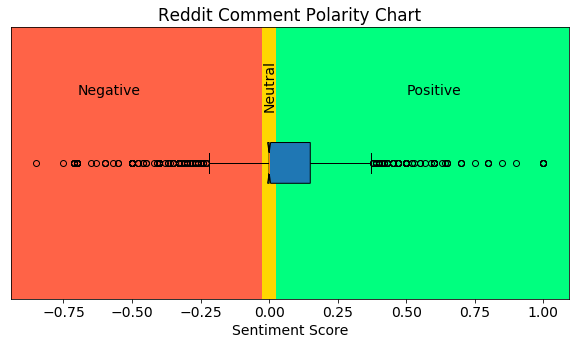

In [10]:
scores = sentiments['Sentiment Score']
orig_font_size = plt.rcParams['font.size']
plt.rcParams['font.size'] = 14

plt.figure(figsize=(10, 5))
_ = plt.boxplot(scores, notch=True, patch_artist=True, vert=False)
left, right = plt.xlim()
plt.xlim(left, right)
plt.axvspan(left, 0, facecolor='tomato', zorder=-100)
plt.axvspan(-.025, 0.025, facecolor='gold', zorder=-100)
plt.axvspan(0.025, right, facecolor='springgreen', zorder=-100)

plt.annotate('Negative', xy=(-0.7, 1.25))
neutral_label = plt.annotate('Neutral', xy=(-.025, 1.2))
neutral_label.set_rotation(90)
plt.annotate('Positive', xy=(0.5, 1.25))

_ = plt.title('Reddit Comment Polarity Chart')
_ = plt.yticks([])
_ = plt.xlabel('Sentiment Score')
plt.show()
plt.rcParams['font.size'] = orig_font_size

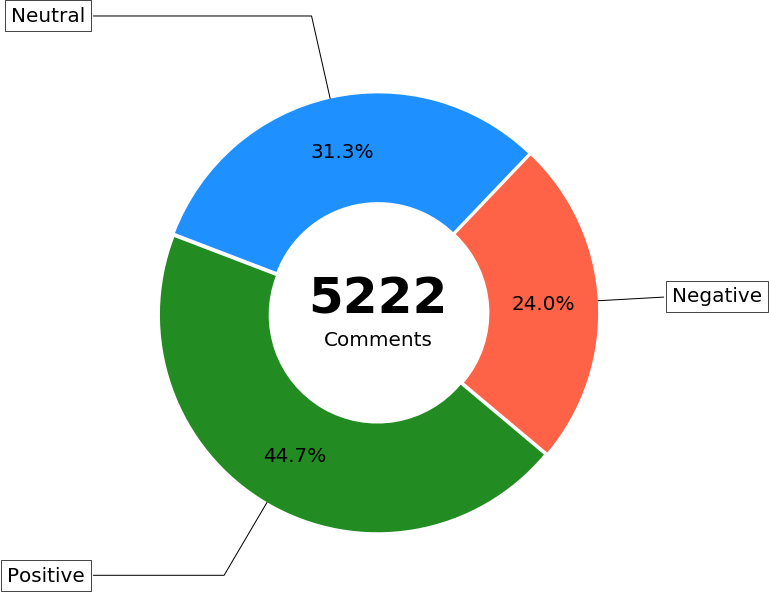

In [11]:
import matplotlib as mp

scores = sentiments['Sentiment Score']
orig_font_size = plt.rcParams['font.size']
plt.rcParams['font.size'] = 20

positive, neutral, negative = 0, 0, 0
for score in scores:
    negative += score < 0
    neutral += score == 0
    positive += score > 0

# labels = ['Noise', 'Unrelated', 'Clean']
labels = ['Negative', 'Neutral', 'Positive']
plt.figure(figsize=(10, 10))
wedges, plt_labels, texts = plt.pie([negative, neutral, positive], wedgeprops=dict(width=0.5), startangle=-40,
# wedges, plt_labels, texts = plt.pie([586, 3689, 947], wedgeprops=dict(width=0.5), startangle=-40,
                                     autopct='%1.1f%%', pctdistance=.75, explode=(.01, .01, .01),
                                     colors=('tomato', 'dodgerblue', 'forestgreen'))

bbox_props = dict(boxstyle="square,pad=0.3", fc="w", ec="k", lw=0.72)
kw = dict(arrowprops=dict(arrowstyle="-"), bbox=bbox_props, zorder=0, va="center")

for i, p in enumerate(wedges):
    ang = (p.theta2 - p.theta1)/2. + p.theta1
    y = np.sin(np.deg2rad(ang))
    x = np.cos(np.deg2rad(ang))
    horizontalalignment = {-1: "right", 1: "left"}[int(np.sign(x))]
    connectionstyle = "angle,angleA=0,angleB={}".format(ang)
    kw["arrowprops"].update({"connectionstyle": connectionstyle})
    plt.annotate(labels[i], xy=(x, y), xytext=(1.35*np.sign(x), 1.4*y), horizontalalignment=horizontalalignment, **kw)
# plt.annotate(str(len(scores)), xy=(-.325, 0), weight='bold', size=50)
plt.annotate('5222', xy=(-.325, 0), weight='bold', size=50)
plt.annotate('Comments', xy=(-.25, -.15))
plt.show()
plt.rcParams['font.size'] = orig_font_size

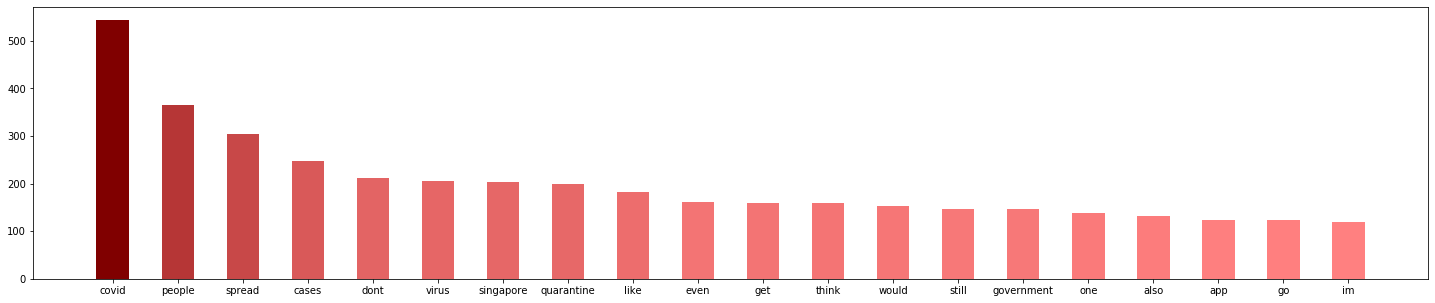

In [12]:
from collections import Counter
import matplotlib as mp

sanitized = comments_df['Comment']

counter = Counter(' '.join(sanitized).split())
top_words = sorted(dict(counter).items(), key=lambda x: x[1], reverse=True)
top_20_words = top_words[:20]
x_data = [x[0] for x in top_20_words]
y_data = [x[1] for x in top_20_words]

data_normalizer = mp.colors.Normalize()
color_map = mp.colors.LinearSegmentedColormap(
    "my_map",
    {
        "red": [(0, 1.0, 1.0),
                (1.0, .5, .5)],
        "green": [(0, 0.5, 0.5),
                  (1.0, 0, 0)],
        "blue": [(0, 0.50, 0.5),
                 (1.0, 0, 0)]
    }
)

plt.figure(figsize=(25, 5))
plt.bar(x_data, y_data, align='center', width=.5, color=color_map(data_normalizer(y_data)))
plt.show()

### 